In [1]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import gensim
import pickle
import nltk
import os

In [2]:
# Load our dataset
path = 'dataset-football_commentary'
filename = 'qb_mentions_12.csv'

df = pd.read_csv(os.path.join(path, filename))

In [3]:
df.head(3)

,Player,Year,Race,Mention,Mention_Cleaned
0,Matt Leinart,2006,White,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', '...",see lot see win lot mike top
1,Matt Leinart,2006,White,"['lot', 'that', 's', '<player>', '&gt;&gt;', '...",lot s mike top need look simple number
2,Matt Leinart,2006,White,"['all', 'you', 'need', 'to', 'do', 'is', 'look...",look simple number life starter man


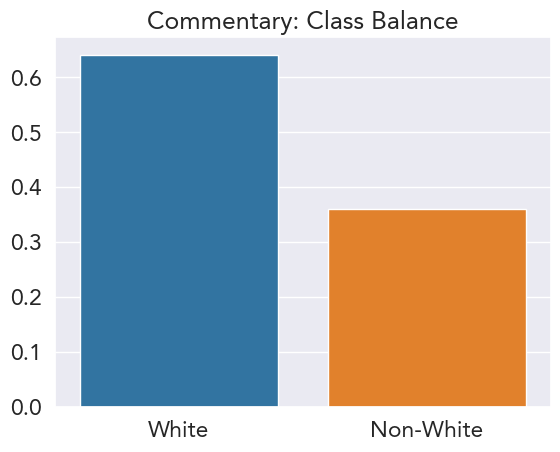

In [4]:
y = df['Race'].value_counts() / len(df)

plt.rcParams['font.family'] = 'Avenir'
sns.set(font='Avenir', font_scale=1.5)
sns.barplot(x=y.index, y=y, palette=['tab:blue', 'tab:orange']).set_title('Commentary: Class Balance')
plt.ylabel('')
plt.show()

In [5]:
# Training Data
X_train = df['Mention_Cleaned']
y_train = np.asarray(df['Race'].map({'White' : 0, 'Non-White' : 1}))

vectorizer = TfidfVectorizer(use_idf=True)
X_train = vectorizer.fit_transform(X_train)

print(X_train.shape)
print(y_train.shape)

(36571, 14860)
(36571,)


## Logistic Regression

In [23]:
# Logistic Regression
grid = {'C' : np.arange(0.1, 1.1, 0.1), 
        'penalty' : ['l1'],
        'solver' : ['liblinear', 'saga'],
        'max_iter' : [100000]} 

classifier = LogisticRegression()
classifier_cv = GridSearchCV(classifier, grid, cv=10, scoring='f1_micro')
classifier_cv.fit(X_train,y_train)

print('Tuned Hyperparameters: ',  classifier_cv.best_params_)
print('F1 :', classifier_cv.best_score_)

Tuned Hyperparameters:  {'C': 0.4, 'max_iter': 100000, 'penalty': 'l1', 'solver': 'liblinear'}
F1 : 0.6490664712312031


In [6]:
classifier = LogisticRegression(C=0.4, max_iter=100000, penalty='l1', solver='liblinear')
classifier.fit(X_train, y_train)

LogisticRegression(C=0.4, max_iter=100000, penalty='l1', solver='liblinear')

In [40]:
# Save our dataframe
checkpoint = '__checkpoints'
filename = 'commentary-coeff_logreg.csv'

important_tokens = pd.DataFrame(data=classifier.coef_[0], index=vectorizer.get_feature_names_out(), columns=['Coefficient']).reset_index().rename(columns={'index':'Word'}).reset_index().rename(columns={'index':'Index'})
important_tokens = important_tokens.sort_values('Coefficient', ascending=False).reset_index(drop=True)
important_tokens.to_csv(os.path.join(checkpoint, filename), index=False)

In [7]:
# Load our dataframe
checkpoint = '__checkpoints'
filename = 'commentary-coeff_logreg.csv'

important_tokens = pd.read_csv(os.path.join(checkpoint, filename))
important_tokens.head(5)

,Index,Word,Coefficient
0,7972,louisville,10.829044
1,14136,verne,9.746412
2,7086,josh,7.887956
3,5445,gerard,7.615849
4,12941,syracuse,6.086978


In [8]:
matrix = X_train.todense()

for index, row in important_tokens.iterrows():
    if index == 0:
        train_df = pd.DataFrame(X_train.todense()[:, row['Index']], columns=[important_tokens[important_tokens['Index'] == row['Index']]['Word'].reset_index(drop=True)[0]])
    else:
        train_df = pd.concat([train_df, pd.DataFrame(X_train.todense()[:, row['Index']], columns=[important_tokens[important_tokens['Index'] == row['Index']]['Word'].reset_index(drop=True)[0]])], axis=1)
        
train_df.shape

(36571, 440)

In [9]:
model = sm.Logit(y_train, train_df).fit(maxiter=100000, method='bfgs')

Optimization terminated successfully.
         Current function value: 0.588598
         Iterations: 342
         Function evaluations: 347
         Gradient evaluations: 347


In [48]:
# Save our Model
checkpoint = '__checkpoints'
filename = 'commentary-logit_model'

model.save(os.path.join(checkpoint, filename))

In [10]:
# Load our Model
checkpoint = '__checkpoints'
filename = 'commentary-logit_model'

model = sm.load(os.path.join(checkpoint, filename))

In [13]:
# Define function to output plot of the model coefficients

def coefplot(results, figsize=(15, 10), sign=False, title='Coefficients of Features w/ 95% Confidence Intervals'):
    
    plt.rcParams['font.family'] = 'Avenir'

    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    coef_df = coef_df.rename(columns=coef_df.iloc[0]).drop(0, axis=0).reset_index(drop=True)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])
    
    # Only Significat Features
    if sign:
        coef_df = coef_df[coef_df['P>|z|'].astype(float) < 0.05]

    ### Plot Coefficients ###

    # Labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster' will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', 
                 kind='bar', ax=ax, 
                 color='none', fontsize=22, 
                 ecolor='steelblue', capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title(title, fontsize=90)
    ax.set_ylabel('Coefficients', fontsize=60)
    ax.set_xlabel('Words', fontsize=60)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', 
               s=80, 
               y=coef_df['coef'], 
               color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

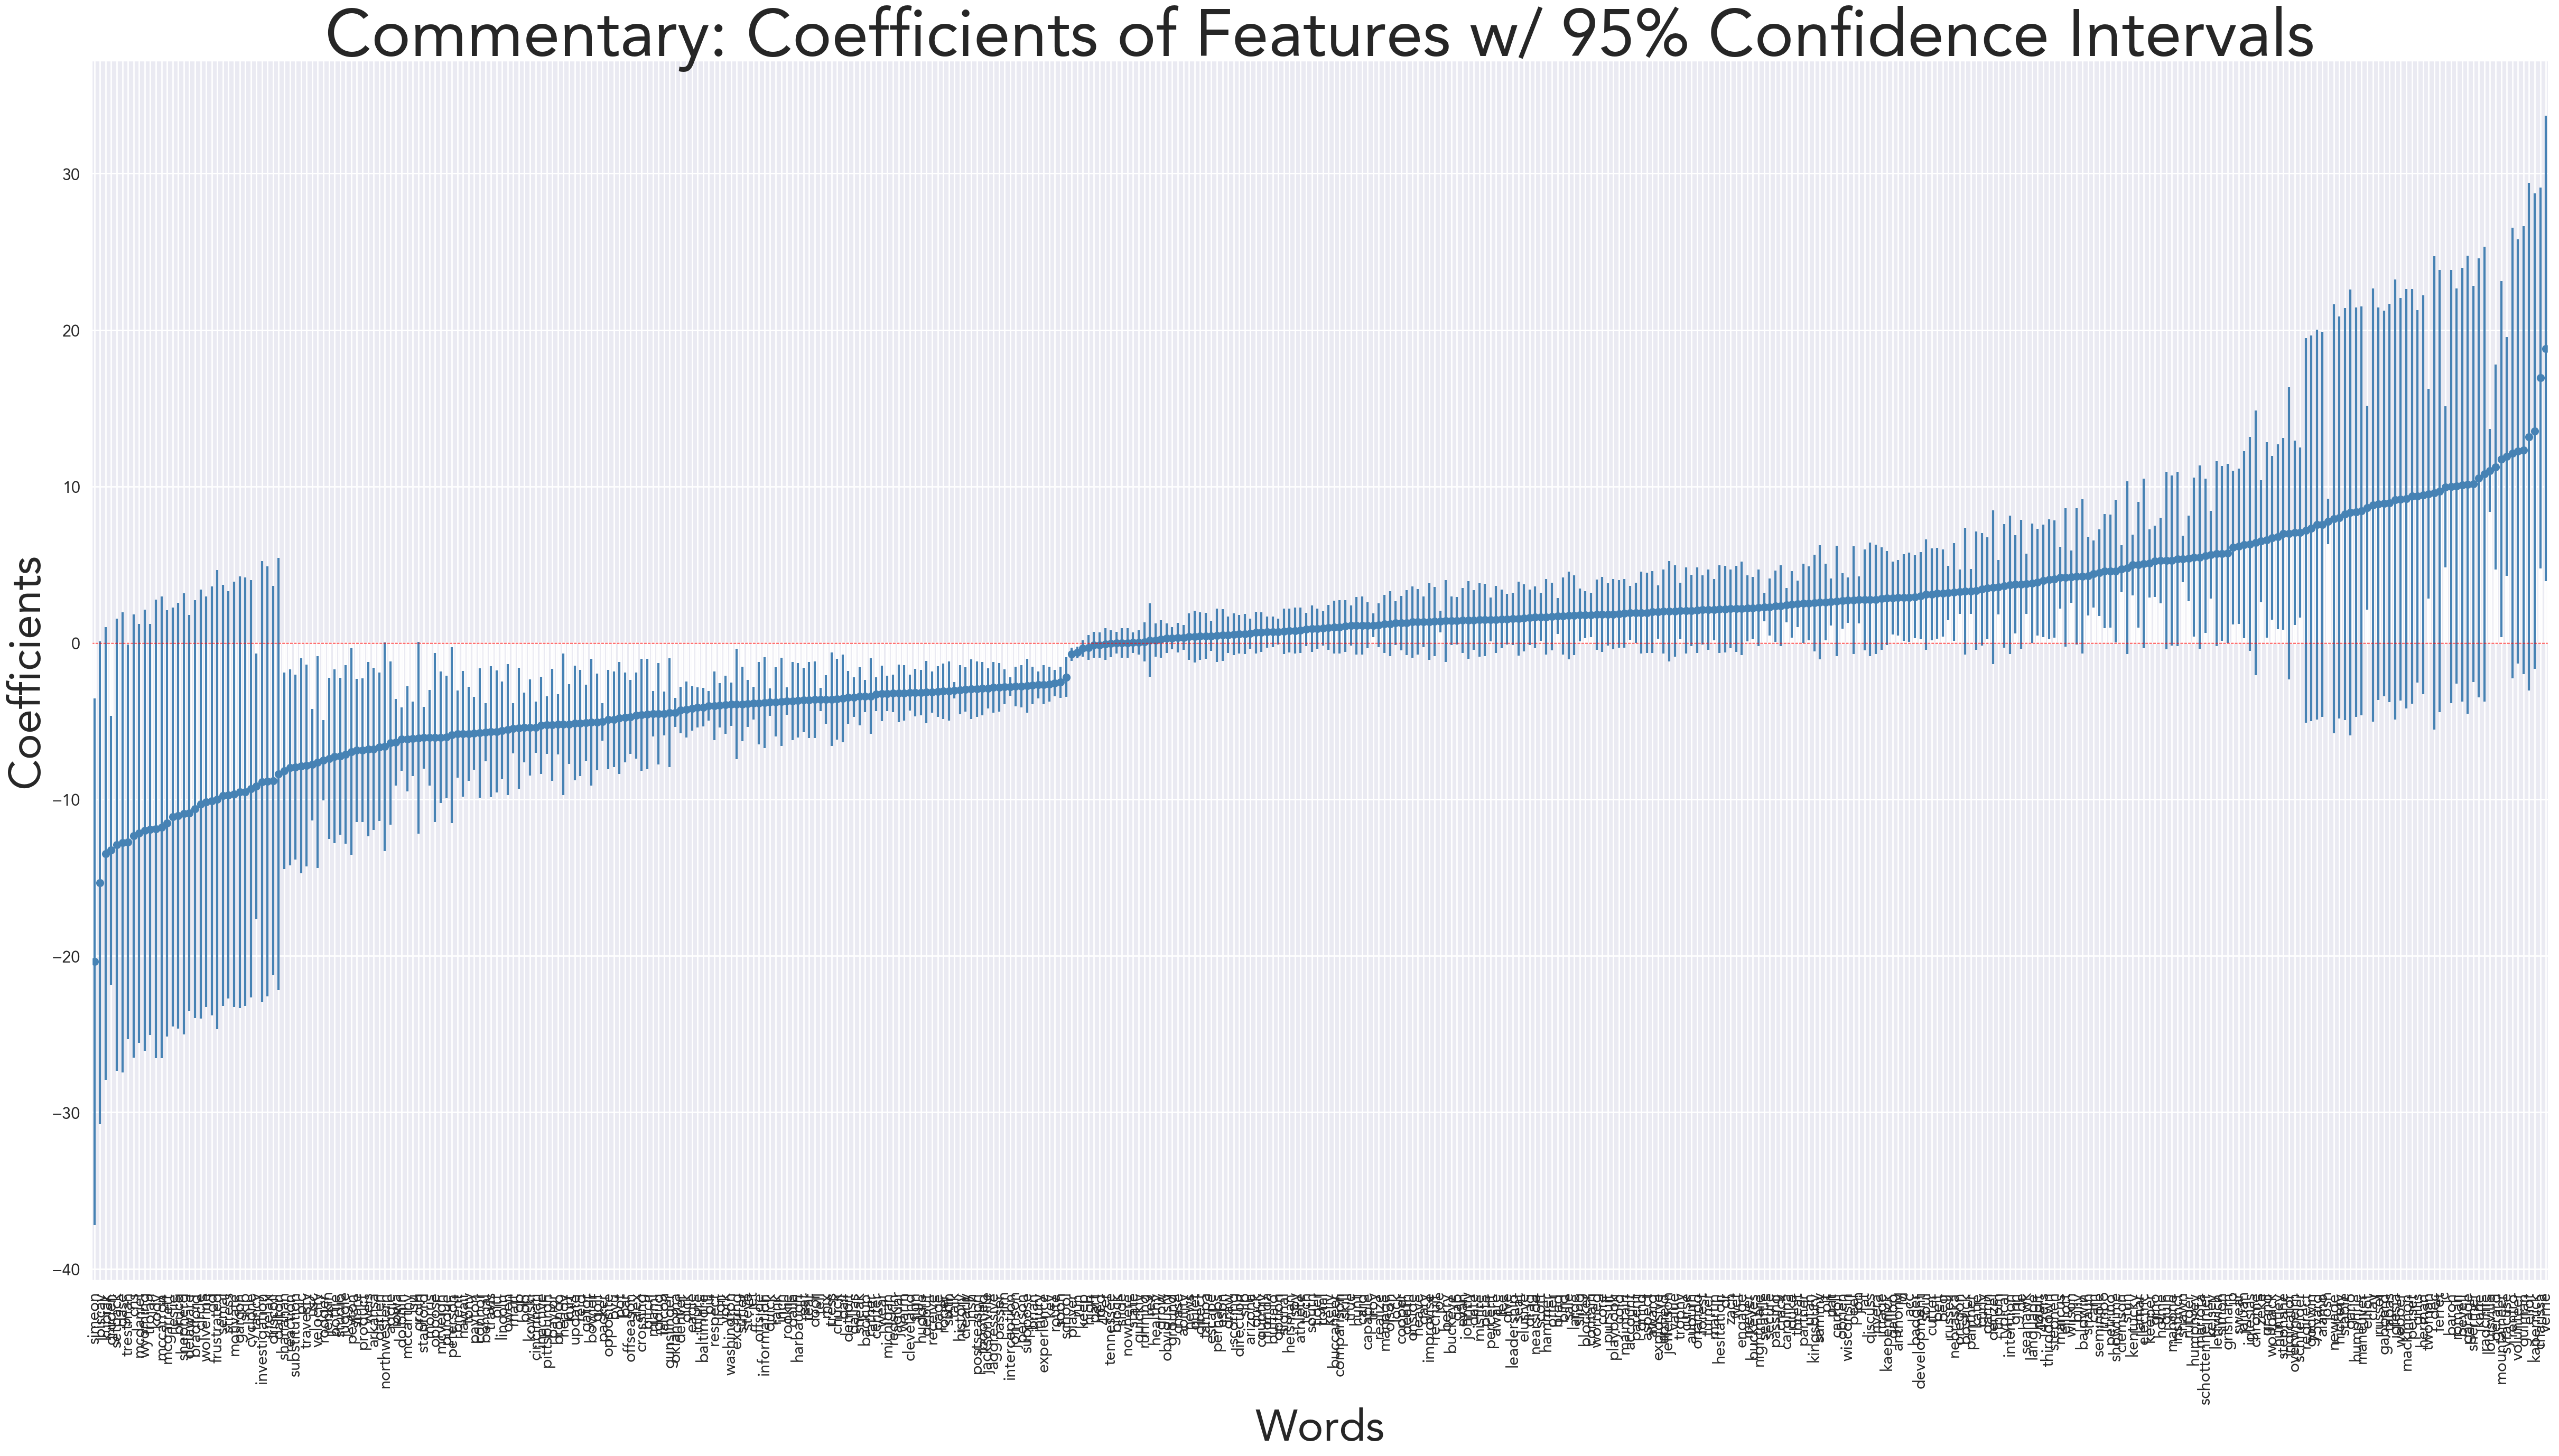

In [14]:
coefplot(model, (60, 30), title='Commentary: Coefficients of Features w/ 95% Confidence Intervals')

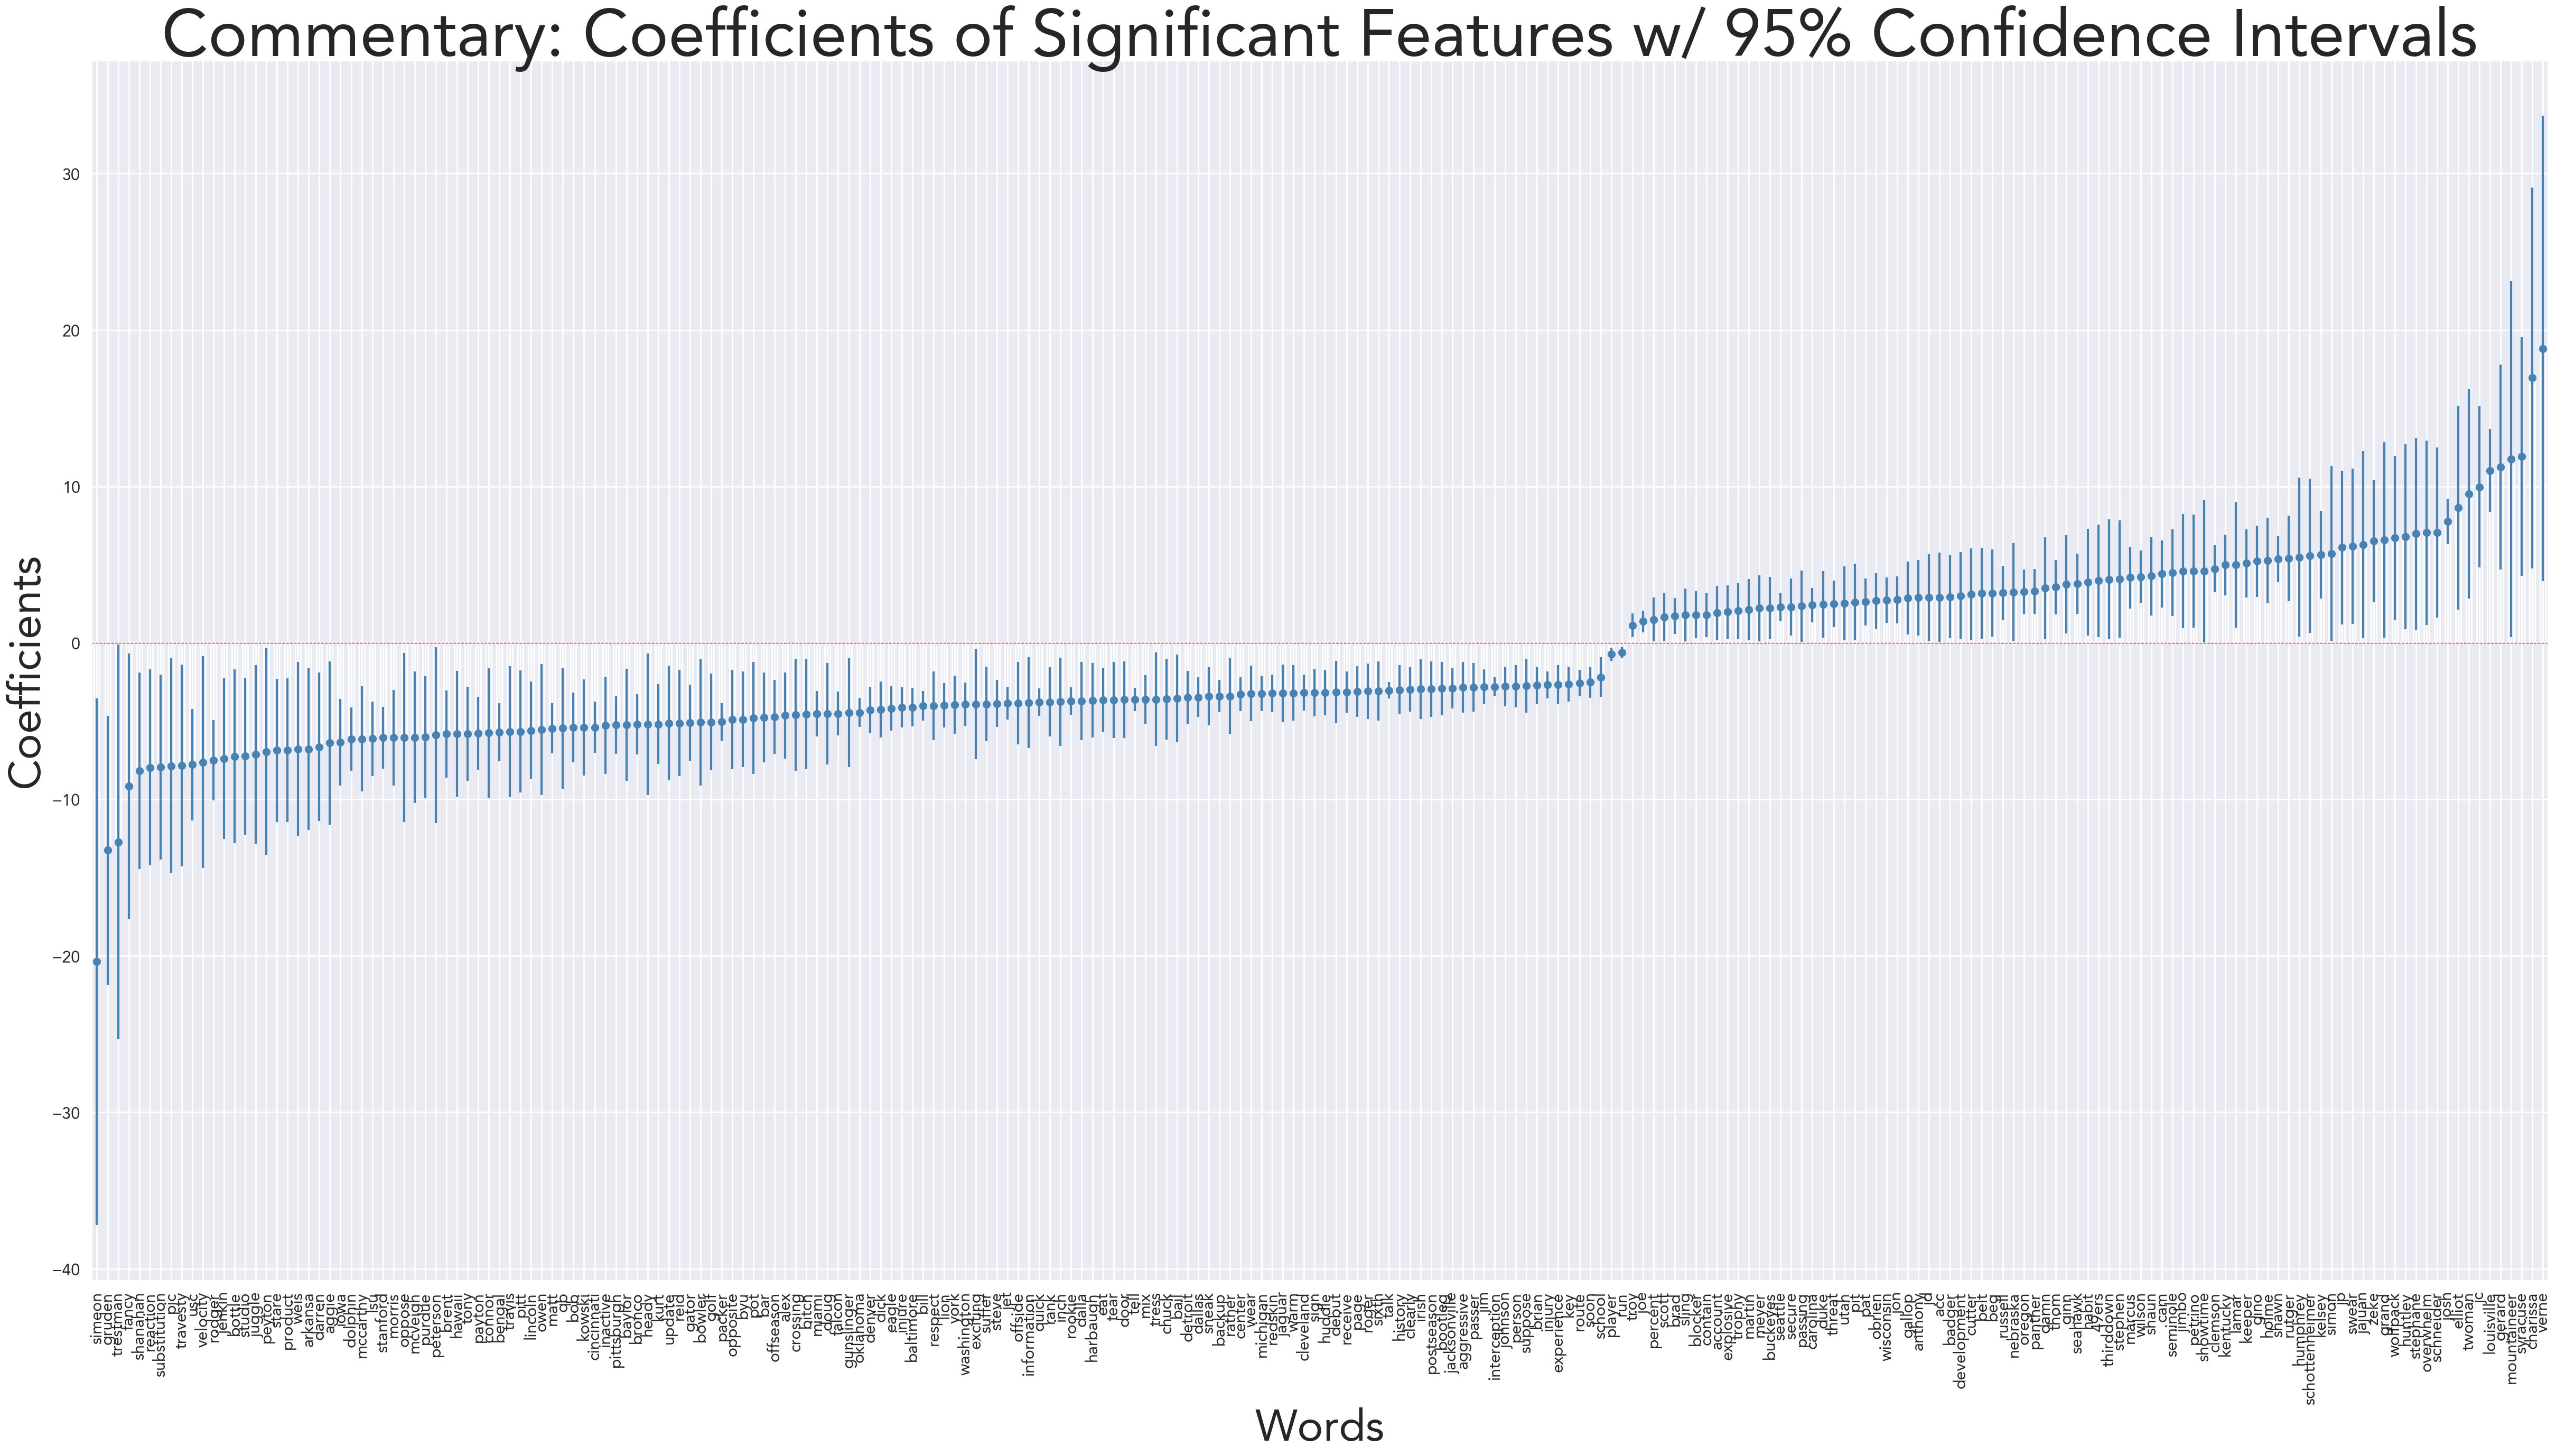

In [15]:
coefplot(model, (60, 30), sign=True, title='Commentary: Coefficients of Significant Features w/ 95% Confidence Intervals')

In [16]:
coef_df = pd.DataFrame(model.summary().tables[1].data)
coef_df = coef_df.rename(columns=coef_df.iloc[0]).drop(0, axis=0).reset_index(drop=True)
coef_df

,,coef,std err,z,P>|z|,[0.025,0.975]
0,louisville,11.0198,1.345,8.191,0.000,8.383,13.657
1,verne,18.8164,7.591,2.479,0.013,3.939,33.694
2,josh,7.7740,0.739,10.515,0.000,6.325,9.223
3,gerard,11.2350,3.342,3.362,0.001,4.685,17.785
4,syracuse,11.9154,3.889,3.064,0.002,4.294,19.537
...,...,...,...,...,...,...,...
435,usc,-7.7835,1.818,-4.282,0.000,-11.346,-4.221
436,rodger,-7.5006,1.315,-5.704,0.000,-10.078,-4.923
437,biscay,-15.3348,7.875,-1.947,0.051,-30.769,0.099
438,gruden,-13.2528,4.384,-3.023,0.003,-21.846,-4.659


## Random Forest

In [25]:
# Random Forest
grid = {'criterion' : ['gini', 'entropy'],
        'max_depth': [100, None],
        'max_features': ['sqrt'],
        'n_estimators': [100, 500]}

classifier = RandomForestClassifier()
classifier_cv = GridSearchCV(classifier, grid, cv=5, scoring='f1_micro')
classifier_cv.fit(X_train, y_train)

print('Tuned Hyperparameters: ',  classifier_cv.best_params_)
print('F1 :', classifier_cv.best_score_)

Tuned Hyperparameters:  {'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100}
F1 : 0.6456483777868864


In [26]:
classifier = RandomForestClassifier(criterion='gini', max_depth=100, max_features='sqrt', n_estimators=100)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=100)

In [27]:
features = vectorizer.get_feature_names_out()
fi = classifier.feature_importances_
importance = [(features[i], fi[i]) for i in range(len(features))]

important_tokens = pd.DataFrame(importance)
important_tokens.columns = ['Feature', 'Importance']
important_tokens = important_tokens.sort_values('Importance', ascending=False)

In [28]:
# Save our dataframe
checkpoint = '__checkpoints'
filename = 'commentary-coeff_randfor.csv'

important_tokens.to_csv(os.path.join(checkpoint, filename), index=False)

In [23]:
# Load our dataframe
checkpoint = '__checkpoints'
filename = 'commentary-coeff_randfor.csv'

important_tokens = pd.read_csv(os.path.join(checkpoint, filename))

In [24]:
def plot_feature_importance(df, title):
    
    plt.rcParams['font.family'] = 'Avenir'

    # Create arrays from feature importance and feature names
    feature_importance = np.array(df['Importance'])
    feature_names = np.array(df['Feature'])

    # Create a DataFrame using a Dictionary
    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    fi_df = fi_df.head(50)

    # Define size of bar plot
    plt.figure(figsize=(30, 20))
    
    # Plot Searborn bar chart
    sns.set_palette(reversed(sns.color_palette('Blues_d', n_colors=50)), n_colors=50)
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    # Add chart labels
    plt.title(title, fontsize=45)
    plt.yticks(fontsize=18)
    plt.xlabel('Feature Importance', fontsize=30)
    plt.ylabel('Words', fontsize=30)

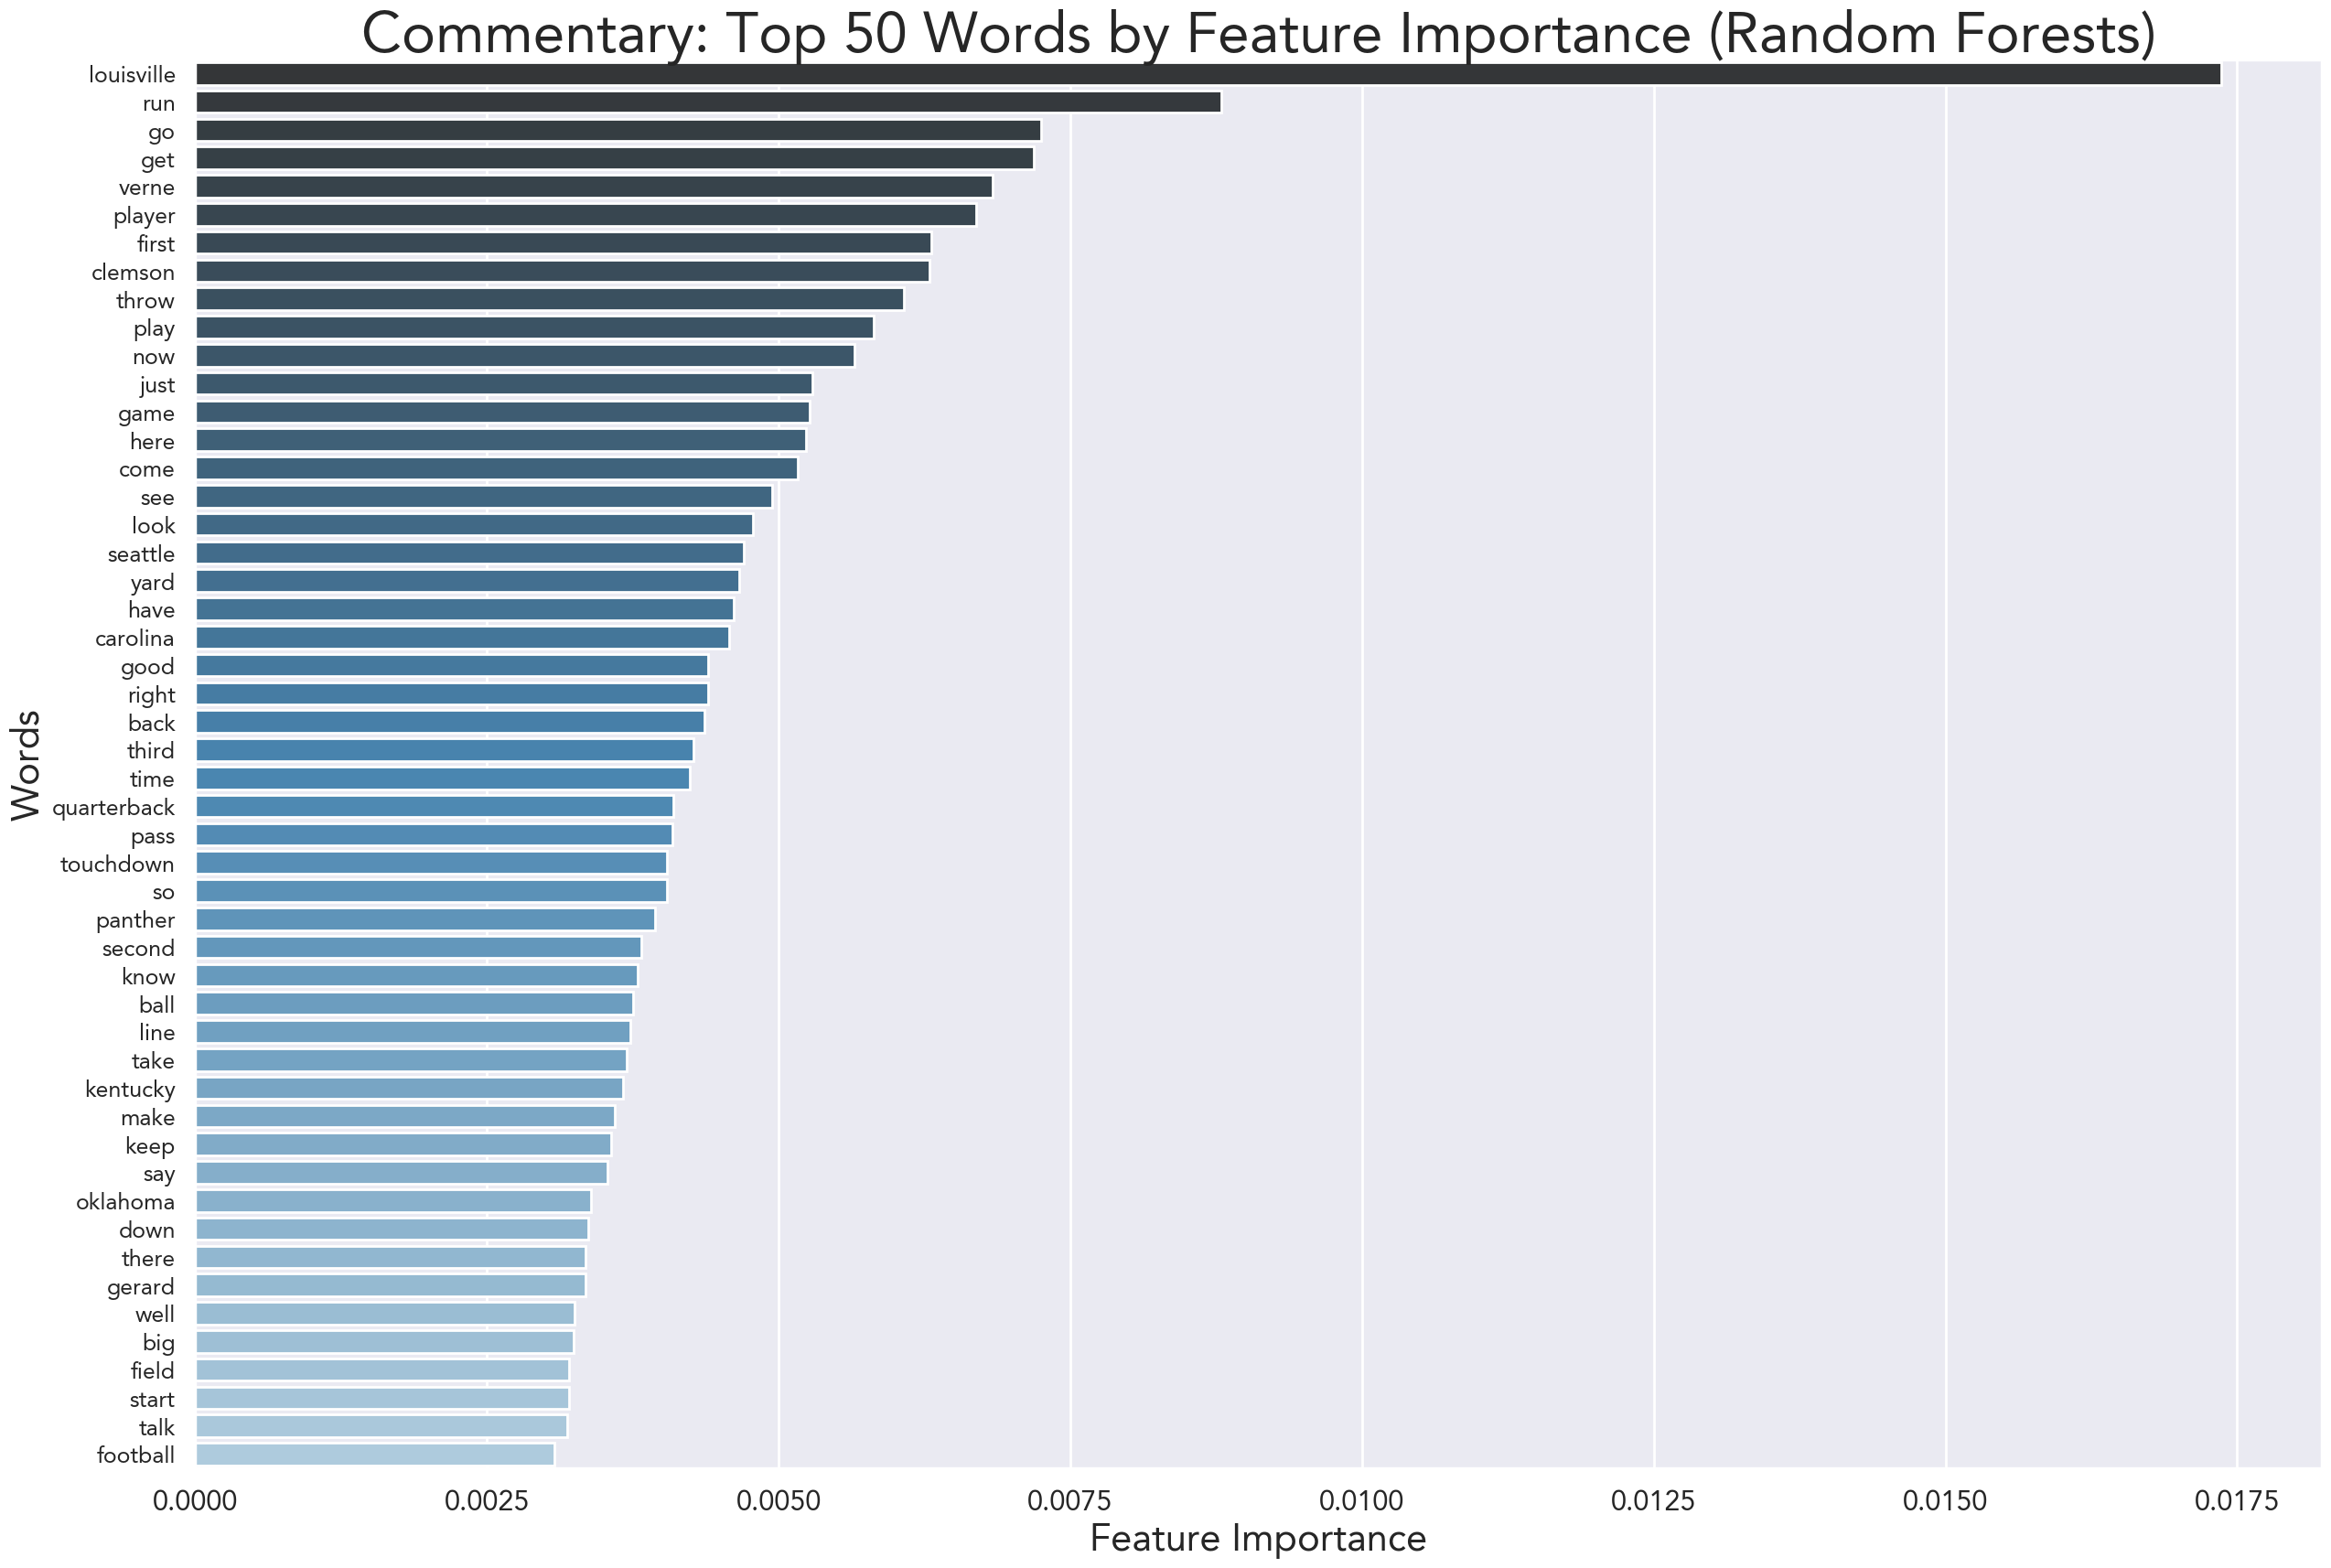

In [25]:
plot_feature_importance(important_tokens, title='Commentary: Top 50 Words by Feature Importance (Random Forests)')